In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras
from keras import layers, activations
from os import path
from PIL import Image
import pickle
from concurrent import futures
from matplotlib import pyplot as plt

trainingDataDir = 'o:/temp/pixiv/training/'
targetSize = (224, 224)
targetShape = (224, 224, 3)
seed = 1

In [2]:
data = pd.read_csv(path.join(trainingDataDir, 'score.csv'),index_col='img')
data.head()

,score
img,
19401409_p0.png,1.0
21485313_p0.png,1.0
39425878_p0.jpg,2.0
39508939_p0.jpg,2.0
40505381_p0.jpg,1.0


In [3]:
# create training and validation set
data1 = data.sample(frac=0.8, random_state=seed)
data2 = data.drop(data1.index)

In [4]:
def process_img(imgName):
    img = Image.open(path.join(trainingDataDir, imgName))
    xx = max(img.size)
    newImg = Image.new('RGB', (xx, xx))
    newImg.paste(img, (int((xx - img.size[0]) / 2), int(
        (xx - img.size[1]) / 2)))
    newImg = newImg.resize(targetSize, Image.BICUBIC)
    return np.array(newImg)


def create_dateset(data):
    # dx,dy = ([],[])
    with futures.ThreadPoolExecutor(max_workers=12) as executor:
        trainX = np.array(list(executor.map(process_img, data.index)))
        trainY = []
        for i in data.index:
            score = int(data.loc[i, 'score'])
            scoreOneHot = np.zeros(3)
            scoreOneHot[score - 1] = 1
            trainY.append(scoreOneHot)
        trainY = np.array(trainY)
        return trainX, trainY


def create_datasets(data):
    data1 = data.sample(frac=0.8, random_state=seed)
    data2 = data.drop(data1.index)
    (trainX, trainY) = create_dateset(data1)
    (testX, testY) = create_dateset(data2)
    return (trainX, trainY), (testX, testY)


def load_data(dataPath):
    if path.exists(dataPath):
        with open(dataPath, 'rb') as f:
            return pickle.load(f)
    else:
        with open('ds.pickle', 'wb') as f:
            (trainX, trainY), (testX, testY) = create_datasets(data)
            pickle.dump(((trainX, trainY), (testX, testY)), f)
        return (trainX, trainY), (testX, testY)

In [5]:
(trainX, trainY), (testX, testY) = load_data('ds.pickle')

In [6]:
mobNet = keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                     weights='imagenet',
                                                     input_shape=targetShape)
for layer in mobNet.layers:
    layer.trainable = False


In [7]:
inputLayer = layers.Input(shape=targetShape)
# preprocess
x = layers.RandomFlip()(inputLayer)
x = layers.RandomZoom(height_factor=0.2, width_factor=0.2)(x)
x = layers.RandomRotation(0.2)(x)
x = layers.Rescaling(scale=1. / 127.5, offset=-1)(x)
x = mobNet(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048)(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(2048)(x)
x = layers.ReLU()(x)
outputLayer = layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs=inputLayer, outputs=outputLayer)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                      

In [8]:
cbs = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                  patience=20,
                                  verbose=1,
                                  restore_best_weights=True)
]
model.fit(trainX, trainY, batch_size=64, epochs=1000, validation_split=0.2,callbacks=cbs)


Epoch 1/1000
39/39 [==============================] - 11s 148ms/step - loss: 1.7111 - accuracy: 0.4487 - val_loss: 0.9930 - val_accuracy: 0.5096
Epoch 2/1000
39/39 [==============================] - 5s 122ms/step - loss: 0.9435 - accuracy: 0.5449 - val_loss: 0.9042 - val_accuracy: 0.5609
Epoch 3/1000
39/39 [==============================] - 5s 126ms/step - loss: 0.9228 - accuracy: 0.5493 - val_loss: 0.9031 - val_accuracy: 0.5641
Epoch 4/1000
39/39 [==============================] - 5s 123ms/step - loss: 0.8932 - accuracy: 0.5854 - val_loss: 0.9003 - val_accuracy: 0.5785
Epoch 5/1000
39/39 [==============================] - 5s 121ms/step - loss: 0.8566 - accuracy: 0.5978 - val_loss: 0.9133 - val_accuracy: 0.5385
Epoch 6/1000
39/39 [==============================] - 5s 121ms/step - loss: 0.8567 - accuracy: 0.5998 - val_loss: 0.8694 - val_accuracy: 0.5737
Epoch 7/1000
39/39 [==============================] - 5s 122ms/step - loss: 0.8227 - accuracy: 0.6323 - val_loss: 0.8890 - val_accuracy

In [9]:
# model = keras.models.load_model('model-dp2-06280.h5')

[[0.9785331  0.00665833 0.01480863]]
pred: 1
y: 3


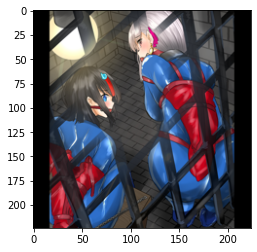

In [23]:
import random
i = random.randint(0, len(testX))
pred = model.predict(testX[i:i + 1])
print(pred)
print('pred:', np.argmax(pred[0]) + 1)
print('y:', np.argmax(testY[i:i + 1]) + 1)
plt.imshow(testX[i])


In [11]:
model.evaluate(testX, testY)

25/25 [==============================] - 1s 48ms/step - loss: 0.9306 - accuracy: 0.6483


[0.9305700659751892, 0.6482670307159424]

In [12]:
model.save('model-dp2-l2.h5')

In [24]:
with open('ds.pickle', 'wb') as f:
    pickle.dump(((trainX, trainY), (testX, testY)), f)
